In [1]:
from pathlib import Path
import pandas as pd
import os

# Establece la raíz del proyecto manualmente
project_root = Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak") # sobremesa
#project_root = Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak") # portátil

# Cambia el directorio de trabajo actual a esa raíz
os.chdir(project_root)

print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


In [2]:
# ----------------------------------------------
# Paso 1: Cargar y preparar los datasets
# ----------------------------------------------

import pandas as pd

# === Cargar datasets ===
future_logs = pd.read_csv("data/processed/future_stars_cleaned_matchlogs.csv")
future_meta = pd.read_csv("data/processed/future_stars_cleaned_metadata.csv")

print("✅ Datasets cargados:")
print(f"- future_logs: {future_logs.shape}")
print(f"- future_meta: {future_meta.shape}")

# === Validación previa: columnas duplicadas esperadas en el merge ===
cols_logs = set(future_logs.columns)
cols_meta = set(future_meta.columns)
common_cols = cols_logs.intersection(cols_meta)
print("\n🔁 Columnas en común antes del merge:")
print(common_cols)

# === Convertir fechas ===
future_logs['Date'] = pd.to_datetime(future_logs['Date'], format='%Y-%m-%d', errors='coerce')
future_meta['Birth_date'] = pd.to_datetime(future_meta['Birth_date'], format='%Y-%m-%d', errors='coerce')

# === Merge: mantenemos columnas del matchlog en caso de duplicado ===
future_df = future_logs.merge(
    future_meta[['Player_ID', 'Birth_date', 'Position']],
    on='Player_ID',
    how='left'
)

# Eliminar columnas duplicadas del metadata (con sufijo '_y')
duplicated_suffix_cols = [col for col in future_df.columns if col.endswith('_y')]
if duplicated_suffix_cols:
    print("\n⚠️ Columnas duplicadas eliminadas del metadata (sufijo '_y'):")
    print(duplicated_suffix_cols)
    future_df.drop(columns=duplicated_suffix_cols, inplace=True)

# Renombrar columnas '_x' a nombre original
future_df.columns = [col.replace('_x', '') if col.endswith('_x') else col for col in future_df.columns]

# === Calcular edad ===
future_df['Age'] = (future_df['Date'] - future_df['Birth_date']).dt.days / 365.25
# Detectar filas donde 'Player_name' es igual a 'Player Name'
future_df = future_df[future_df['Player_name'] != 'Player Name'].copy()


# === Resumen final ===
print("\n📄 Estructura final del DataFrame combinado:")
print(future_df.shape)
print("\n🧾 Columnas finales del dataset future_df:")
print(future_df.columns.tolist())

# Mostrar muestra de datos
display(future_df.head())




✅ Datasets cargados:
- future_logs: (1053, 46)
- future_meta: (8, 12)

🔁 Columnas en común antes del merge:
{'Player_ID', 'Position', 'Player_name'}

⚠️ Columnas duplicadas eliminadas del metadata (sufijo '_y'):
['Position_y']

📄 Estructura final del DataFrame combinado:
(1052, 48)

🧾 Columnas finales del dataset future_df:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc', 'Birth_d

,Player_name,Player_ID,Seasons,Date,Day,Competition,Round,Home_Away,Result,Player_team,...,Goal_creating_actions,Passes_completed,Passes_att,Percent_passes,Progressive_passes,Feet_control,Progressive_control,Dribling_suc,Birth_date,Age
1,Lamine Yamal,82ec26c1,2022-2023,2023-04-29,Sat,La Liga,Matchweek 32,Home,W 4–0,Barcelona,...,0,8,2,88.9,2,9,0,0,2007-07-13,15.794661
2,Lamine Yamal,82ec26c1,nat_tm,2023-09-08,Fri,UEFA Euro Qualifying,Group stage,Away,W 7–1,Spain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-13,16.156057
3,Lamine Yamal,82ec26c1,nat_tm,2023-09-12,Tue,UEFA Euro Qualifying,Group stage,Home,W 6–0,Spain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-13,16.167009
4,Lamine Yamal,82ec26c1,nat_tm,2023-11-16,Thu,UEFA Euro Qualifying,Group stage,Away,W 3–1,Spain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-13,16.344969
5,Lamine Yamal,82ec26c1,nat_tm,2023-11-19,Sun,UEFA Euro Qualifying,Group stage,Home,W 3–1,Spain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-13,16.353183


In [3]:
# ----------------------------------------------
# Paso EDA 1: Análisis estructural inicial del dataset future_df
# ----------------------------------------------

print("✅ Dimensiones del dataset:")
print(f"Filas: {future_df.shape[0]}, Columnas: {future_df.shape[1]}\n")

print("🧾 Columnas del dataset:")
print(future_df.columns.tolist())

print("\n🔍 Tipos de datos:")
display(future_df.dtypes)

print("\n🧼 Conteo de valores nulos por columna:")
display(future_df.isnull().sum().sort_values(ascending=False))

print("\n🧮 Número de valores únicos por columna:")
display(future_df.nunique().sort_values())

print("\n🧪 Muestra aleatoria de 5 filas:")
display(future_df.sample(5, random_state=42))

# Columnas con un único valor (sin variabilidad)
constant_cols = [col for col in future_df.columns if future_df[col].nunique() <= 1]
if constant_cols:
    print("\n⚠️ Columnas constantes (sin valor informativo):")
    print(constant_cols)
else:
    print("\n✅ No hay columnas constantes.")

# Columnas duplicadas
duplicated_cols = future_df.columns[future_df.columns.duplicated()].tolist()
if duplicated_cols:
    print("\n⚠️ Columnas duplicadas:")
    print(duplicated_cols)
else:
    print("\n✅ No hay columnas duplicadas.")


✅ Dimensiones del dataset:
Filas: 1052, Columnas: 48

🧾 Columnas del dataset:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc', 'Birth_date', 'Age']

🔍 Tipos de datos:


Player_name                      object
Player_ID                        object
Seasons                          object
Date                     datetime64[ns]
Day                              object
Competition                      object
Round                            object
Home_Away                        object
Result                           object
Player_team                      object
Rival_team                       object
Start                            object
Position                         object
Minutes                          object
Goals                            object
Assists                          object
Penalty_kick                     object
Penalty_kick_att                 object
Shots                            object
Shots_on_target                  object
Yellow_cards                     object
Red_cards                        object
Fouls_committed                  object
Fouls_drawn                      object
Offsides                         object



🧼 Conteo de valores nulos por columna:


Offsides                 1052
Crosses                  1052
Tackles_won              1052
Own_goals                1052
Penaltys_conceded        1052
Penaltys_won             1052
Fouls_drawn              1052
Fouls_committed          1052
Percent_passes            189
x_assisted_G              175
xG                        175
Tackles                   175
Goal_creating_actions     175
Shot_creating_actions     175
Touches                   175
Blocks                    175
Passes_completed          175
Passes_att                175
Progressive_passes        175
Feet_control              175
Progressive_control       175
Dribling_suc              175
non_penalty_xG            175
Position                   77
Interceptions              39
Shots                      39
Shots_on_target            39
Assists                    18
Minutes                     1
Player_name                 0
Player_ID                   0
Day                         0
Goals                       0
Player_tea


🧮 Número de valores únicos por columna:


Offsides                   0
Crosses                    0
Tackles_won                0
Own_goals                  0
Penaltys_conceded          0
Penaltys_won               0
Fouls_drawn                0
Fouls_committed            0
Red_cards                  2
Yellow_cards               2
Penalty_kick               2
Penalty_kick_att           2
Home_Away                  3
Start                      3
Assists                    4
Goals                      4
Interceptions              5
Blocks                     6
Goal_creating_actions      6
Shots_on_target            7
Day                        7
Tackles                    8
Player_ID                  8
Player_name                8
Birth_date                 8
Seasons                   11
Shots                     11
Dribling_suc              14
Shot_creating_actions     14
Progressive_passes        15
x_assisted_G              16
Player_team               16
Progressive_control       16
non_penalty_xG            17
xG            


🧪 Muestra aleatoria de 5 filas:


,Player_name,Player_ID,Seasons,Date,Day,Competition,Round,Home_Away,Result,Player_team,...,Goal_creating_actions,Passes_completed,Passes_att,Percent_passes,Progressive_passes,Feet_control,Progressive_control,Dribling_suc,Birth_date,Age
97,Lamine Yamal,82ec26c1,2024-2025,2025-01-26,Sun,La Liga,Matchweek 21,Home,W 7–1,Barcelona,...,1,29,9,78.4,3,35,3,5,2007-07-13,17.541410
683,Jamal Musiala,2c0558b8,2021-2022,2021-12-14,Tue,Bundesliga,Matchweek 16,Away,W 5–0,Bayern Munich,...,0,38,2,95.0,5,27,1,1,2003-02-26,18.798084
320,Endrick,a2728fbf,2024-2025,2025-01-19,Sun,La Liga,Matchweek 20,Home,W 4–1,Real Madrid,...,0,3,0,100.0,1,2,0,0,2006-07-21,18.499658
732,Jamal Musiala,2c0558b8,nat_tm,2024-09-07,Sat,UEFA Nations League,League A,Home,W 5–0,Germany,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-02-26,21.530459
523,Hugo Ekitike,5b92d896,2023-2024,2023-08-12,Sat,Ligue 1,Matchweek 1,Home,D 0–0,Paris S-G,...,0,7,0,87.5,1,11,0,0,2002-06-20,21.144422



⚠️ Columnas constantes (sin valor informativo):
['Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded']

✅ No hay columnas duplicadas.


In [4]:
print(future_df[['Goals', 'Assists', 'Minutes', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards']].dtypes)


Goals              object
Assists            object
Minutes            object
Shots              object
Shots_on_target    object
Yellow_cards       object
Red_cards          object
dtype: object


In [5]:
# Forzar conversión a numérico, convirtiendo strings y NaNs en ceros
cols_to_convert = ['Goals', 'Assists', 'Minutes', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards']
future_df[cols_to_convert] = future_df[cols_to_convert].apply(pd.to_numeric, errors='coerce').fillna(0)

# Ahora sí, agregamos
summary_global = future_df[cols_to_convert].sum().to_frame(name='Total')
display(summary_global)


,Total
Goals,231.0
Assists,135.0
Minutes,57041.0
Shots,1690.0
Shots_on_target,652.0
Yellow_cards,82.0
Red_cards,3.0


In [6]:
# ----------------------------------------------
# Desglose por jugador (totales)
# ----------------------------------------------

summary_by_player = future_df.groupby('Player_name').agg({
    'Goals': 'sum',
    'Assists': 'sum',
    'Minutes': 'sum'
}).sort_values('Goals', ascending=False).reset_index()

display(summary_by_player)


,Player_name,Goals,Assists,Minutes
0,Jamal Musiala,77,38.0,16120.0
1,Hugo Ekitike,44,21.0,7802.0
2,Lamine Yamal,27,35.0,8527.0
3,Endrick,27,1.0,3959.0
4,Désiré Doué,21,16.0,6615.0
5,Mathys Tel,19,8.0,3727.0
6,Warren Zaïre-Emery,9,9.0,7591.0
7,Franco Mastantuono,7,7.0,2700.0


C:\Users\juanm\AppData\Local\Temp\ipykernel_28408\1583193433.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_by_player, x='Goals', y='Player_name', palette='Blues_d')
C:\Users\juanm\AppData\Local\Temp\ipykernel_28408\1583193433.py:13: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


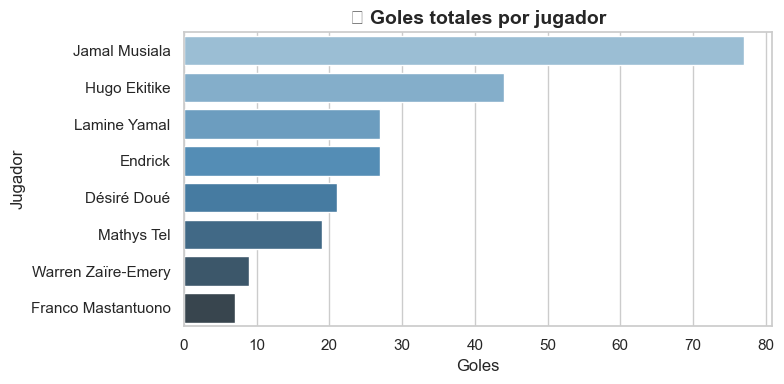

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.barplot(data=summary_by_player, x='Goals', y='Player_name', palette='Blues_d')

plt.title("⚽ Goles totales por jugador", fontsize=14, weight='bold')
plt.xlabel("Goles")
plt.ylabel("Jugador")
plt.tight_layout()
plt.show()


In [8]:
print("🎯 Jugadores disponibles:")
display(future_df[['Player_name', 'Player_ID']].drop_duplicates().reset_index(drop=True))


🎯 Jugadores disponibles:


,Player_name,Player_ID
0,Lamine Yamal,82ec26c1
1,Mathys Tel,829aa60c
2,Endrick,a2728fbf
3,Désiré Doué,9e7483ff
4,Franco Mastantuono,633b2b1f
5,Hugo Ekitike,5b92d896
6,Jamal Musiala,2c0558b8
7,Warren Zaïre-Emery,6b9960cf


In [9]:
# ----------------------------------------------
# Selección de jugador por Player_ID
# ----------------------------------------------

# 👇 Sustituye este ID por el que quieras analizar
player_id = "9e7483ff"

# Extraer nombre solo para mostrar
player_name = future_df.loc[future_df['Player_ID'] == player_id, 'Player_name'].iloc[0]

# Filtrar dataset del jugador
player_df = future_df[future_df['Player_ID'] == player_id].copy()

# Verificación
print(f"🧍 Jugador seleccionado: {player_name} ({player_id})")
display(player_df[['Date', 'Age', 'Minutes', 'Goals', 'Assists']].head())



🧍 Jugador seleccionado: Désiré Doué (9e7483ff)


,Date,Age,Minutes,Goals,Assists
339,2024-08-23,19.222450,29.0,0,0.0
340,2024-09-01,19.247091,26.0,0,1.0
341,2024-09-14,19.282683,28.0,0,0.0
342,2024-09-18,19.293634,28.0,0,0.0
343,2024-09-21,19.301848,64.0,0,0.0


In [10]:
# ----------------------------------------------
# EDA básico del jugador seleccionado (sin rating)
# ----------------------------------------------

# Recontar métricas clave
total_matches = len(player_df)
total_minutes = player_df['Minutes'].sum()
total_goals = player_df['Goals'].sum()
total_assists = player_df['Assists'].sum()
total_ga = total_goals + total_assists
total_yellows = player_df['Yellow_cards'].sum()
total_reds = player_df['Red_cards'].sum()

# Por 90 minutos (si hay minutos totales)
goals_per_90 = total_goals / (total_minutes / 90) if total_minutes > 0 else 0
assists_per_90 = total_assists / (total_minutes / 90) if total_minutes > 0 else 0
ga_per_90 = total_ga / (total_minutes / 90) if total_minutes > 0 else 0

# Armar tabla resumen
eda_summary = pd.DataFrame({
    'Total partidos': [total_matches],
    'Minutos totales': [total_minutes],
    'Goles': [total_goals],
    'Asistencias': [total_assists],
    'G+A': [total_ga],
    'Amarillas': [total_yellows],
    'Rojas': [total_reds],
    'Goles/90': [goals_per_90],
    'Asistencias/90': [assists_per_90],
    'G+A/90': [ga_per_90],
})

# Mostrar tabla
print(f"📊 EDA del jugador: {player_df['Player_name'].iloc[0]}")
display(eda_summary)


📊 EDA del jugador: Désiré Doué


,Total partidos,Minutos totales,Goles,Asistencias,G+A,Amarillas,Rojas,Goles/90,Asistencias/90,G+A/90
0,128,6615.0,21,16.0,37.0,13,0,0.285714,0.217687,0.503401


In [11]:
# ----------------------------------------------
# Paso 2: Calcular rating_per_90 (manteniendo partidos cortos)
# ----------------------------------------------

# 1. Asegurar tipos numéricos
rating_cols = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
player_df[rating_cols] = player_df[rating_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# 2. Definir fórmula
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] >= 1 else 0

# 3. Aplicar cálculo a todos los partidos
player_df['rating_per_90'] = player_df.apply(calculate_rating, axis=1)

# 4. Marcar partidos cortos (p.ej. menos de 30 minutos)
player_df['Short_appearance'] = player_df['Minutes'] < 30

# 5. Métricas globales
total_minutes = player_df['Minutes'].sum()
weighted_rating = (player_df['rating_per_90'] * player_df['Minutes']).sum() / total_minutes if total_minutes > 0 else 0

# 6. Mostrar resultados
print(f"\n⏱️ Minutos totales jugados: {int(total_minutes)}")
print(f"🔹 Partidos totales: {len(player_df)}")
print(f"🔸 Partidos cortos (<30min): {player_df['Short_appearance'].sum()}")
print(f"⭐ Weighted rating_per_90: {weighted_rating:.2f}")

# 7. Vista previa
display(player_df[['Date', 'Minutes', 'Goals', 'Assists', 'rating_per_90', 'Short_appearance']].head())





⏱️ Minutos totales jugados: 6615
🔹 Partidos totales: 128
🔸 Partidos cortos (<30min): 44
⭐ Weighted rating_per_90: 2.79


,Date,Minutes,Goals,Assists,rating_per_90,Short_appearance
339,2024-08-23,29.0,0,0.0,4.034483,True
340,2024-09-01,26.0,0,1.0,14.192308,True
341,2024-09-14,28.0,0,0.0,0.000000,True
342,2024-09-18,28.0,0,0.0,0.321429,True
343,2024-09-21,64.0,0,0.0,1.546875,False


In [12]:
# ----------------------------------------------
# Paso 3: Perfil anual del jugador desde su debut
# ----------------------------------------------

# Asegurar que estamos trabajando sobre el df del jugador
df = player_df.copy()

# 1. Calcular año natural
df['Natural_year'] = df['Date'].dt.year

# 2. Detectar año de debut con minutos jugados
debut_year = df[df['Minutes'] > 0]['Natural_year'].min()

# ⚠️ Validación
if pd.isna(debut_year):
    raise ValueError("❌ El jugador no tiene minutos registrados en ningún año.")

# 3. Año relativo desde debut
df['year_since_debut'] = df['Natural_year'] - debut_year + 1

# 4. Agregación por año
seasonal_agg = df.groupby('year_since_debut').agg({
    'rating_per_90': 'mean',
    'Age': 'mean',
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'Date': 'count'  # número de partidos
}).rename(columns={'Date': 'Matches'}).reset_index()

# 5. Derivar métricas por 90 min
seasonal_agg['goals_per_90'] = seasonal_agg['Goals'] / (seasonal_agg['Minutes'] / 90)
seasonal_agg['assists_per_90'] = seasonal_agg['Assists'] / (seasonal_agg['Minutes'] / 90)
seasonal_agg['ga_per_90'] = (seasonal_agg['Goals'] + seasonal_agg['Assists']) / (seasonal_agg['Minutes'] / 90)

# 6. Pivot para vectorizar
pivot_rating = seasonal_agg.pivot(columns='year_since_debut', values='rating_per_90')
pivot_age = seasonal_agg.pivot(columns='year_since_debut', values='Age')
pivot_minutes = seasonal_agg.pivot(columns='year_since_debut', values='Minutes')

# 7. Renombrar columnas
pivot_rating.columns = [f'rating_year_{i}' for i in pivot_rating.columns]
pivot_age.columns = [f'age_year_{i}' for i in pivot_age.columns]
pivot_minutes.columns = [f'minutes_year_{i}' for i in pivot_minutes.columns]

# 8. Unir en un único perfil vectorizado
player_model_df = pd.concat([pivot_rating, pivot_age, pivot_minutes], axis=1)

# 9. Variables derivadas (con checks)
if 'rating_year_2' in player_model_df.columns and 'rating_year_1' in player_model_df.columns:
    player_model_df['growth_2_1'] = player_model_df['rating_year_2'] - player_model_df['rating_year_1']
if 'rating_year_3' in player_model_df.columns and 'rating_year_2' in player_model_df.columns:
    player_model_df['growth_3_2'] = player_model_df['rating_year_3'] - player_model_df['rating_year_2']
if 'rating_year_3' in player_model_df.columns and 'rating_year_1' in player_model_df.columns:
    player_model_df['rating_trend'] = player_model_df['rating_year_3'] - player_model_df['rating_year_1']
if 'minutes_year_3' in player_model_df.columns and 'minutes_year_1' in player_model_df.columns:
    player_model_df['minutes_trend'] = player_model_df['minutes_year_3'] - player_model_df['minutes_year_1']

# 10. Promedios agregados
player_model_df['avg_rating'] = player_model_df[[col for col in player_model_df.columns if col.startswith('rating_year_')]].mean(axis=1)
player_model_df['sum_minutes'] = player_model_df[[col for col in player_model_df.columns if col.startswith('minutes_year_')]].sum(axis=1)

# 11. Verificación final
print(f"\n🧠 Perfil anual del jugador: {df['Player_name'].iloc[0]}")
display(player_model_df.T)





🧠 Perfil anual del jugador: Désiré Doué


,0,1,2,3
rating_year_1,5.822488,NaN,NaN,NaN
rating_year_2,NaN,1.433931,NaN,NaN
rating_year_3,NaN,NaN,2.741884,NaN
rating_year_4,NaN,NaN,NaN,4.753792
age_year_1,17.299452,NaN,NaN,NaN
age_year_2,NaN,18.064635,NaN,NaN
age_year_3,NaN,NaN,19.056745,NaN
age_year_4,NaN,NaN,NaN,19.761807
minutes_year_1,578.000000,NaN,NaN,NaN
minutes_year_2,NaN,1534.000000,NaN,NaN



📊 Estadísticas anuales del jugador:


,year_since_debut,Goals,Assists,Minutes,Matches,G+A
0,1,3,0.0,578.0,16,3.0
1,2,3,1.0,1534.0,37,4.0
2,3,4,6.0,2383.0,42,10.0
3,4,11,9.0,2120.0,33,20.0


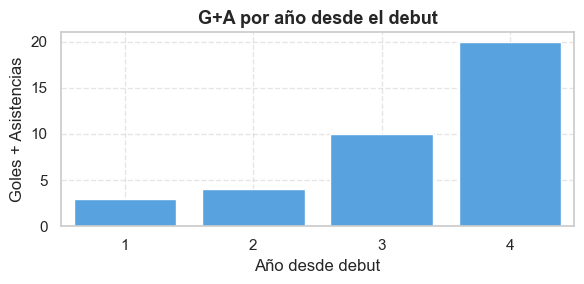

In [13]:
# ----------------------------------------------
# Paso 4: Estadísticas anuales y visualización G+A
# ----------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Asegurar columna 'year_since_debut' está en player_df
if 'year_since_debut' not in player_df.columns:
    player_df['Natural_year'] = player_df['Date'].dt.year
    debut_year = player_df[player_df['Minutes'] > 0]['Natural_year'].min()
    player_df['year_since_debut'] = player_df['Natural_year'] - debut_year + 1

# 2. Agregación anual de métricas
player_stats = player_df.groupby('year_since_debut').agg({
    'Goals': 'sum',
    'Assists': 'sum',
    'Minutes': 'sum',
    'Date': 'count'  # número de partidos
}).rename(columns={'Date': 'Matches'}).reset_index()

player_stats['G+A'] = player_stats['Goals'] + player_stats['Assists']

# 3. Mostrar tabla
print("\n📊 Estadísticas anuales del jugador:")
display(player_stats)

# 4. Gráfico de barras: G+A por año desde el debut
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 3))

sns.barplot(
    data=player_stats,
    x='year_since_debut',
    y='G+A',
    color="#42a5f5",
    ax=ax
)

ax.set_title("G+A por año desde el debut", fontsize=13, weight='bold')
ax.set_xlabel("Año desde debut")
ax.set_ylabel("Goles + Asistencias")
ax.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()
plt.show()



📊 Minutos anuales del jugador:


,year_since_debut,Minutes,Matches
0,1,578.0,16
1,2,1534.0,37
2,3,2383.0,42
3,4,2120.0,33


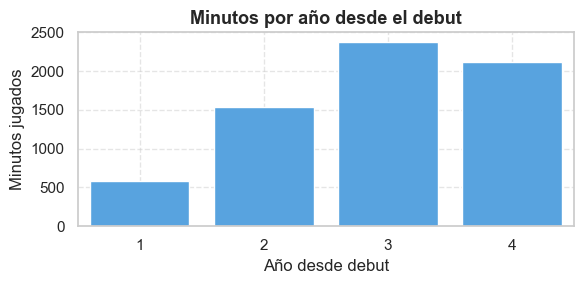

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Asegurar columna 'year_since_debut' está en player_df ---
if 'year_since_debut' not in player_df.columns:
    player_df['Natural_year'] = player_df['Date'].dt.year
    debut_year = player_df.loc[player_df['Minutes'] > 0, 'Natural_year'].min()
    player_df['year_since_debut'] = player_df['Natural_year'] - debut_year + 1

# --- 2. Agregación anual de métricas ---
player_minutes = (
    player_df
    .groupby('year_since_debut')
    .agg(
        Minutes=('Minutes', 'sum'),
        Matches=('Date', 'count')  # número de partidos
    )
    .reset_index()
)

# --- 3. Mostrar tabla ---
print("\n📊 Minutos anuales del jugador:")
display(player_minutes)

# --- 4. Gráfico de barras: Minutos por año desde el debut ---
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 3))

sns.barplot(
    data=player_minutes,
    x='year_since_debut',
    y='Minutes',
    color="#42a5f5",
    ax=ax
)

ax.set_title("Minutos por año desde el debut", fontsize=13, weight='bold')
ax.set_xlabel("Año desde debut")
ax.set_ylabel("Minutos jugados")
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



2025-05-23 10:48:26.104 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-05-23 10:48:26.336 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-05-23 10:48:26.337 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-23 10:48:26.701 
  command:

    streamlit run c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-23 10:48:26.701 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-23 10:48:26.702 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-23 10:48:26.704 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-23 10:48:26.704 Thread 'MainT


🧪 HEAD desde Streamlit para 9e7483ff:
        Date  Minutes  Goals  Assists        Age
0 2024-08-23       29      0        0  19.222450
1 2024-09-01       26      0        1  19.247091
2 2024-09-14       28      0        0  19.282683
3 2024-09-18       28      0        0  19.293634
4 2024-09-21       64      0        0  19.301848
✅ Filas finales en player_model_df: 1
🧠 Vector model input para 9e7483ff (Streamlit):
                            0
year_since_debut             
rating_year_1        5.822488
rating_year_2        1.433931
rating_year_3        2.741884
rating_year_4        4.753792
age_year_1          17.299452
age_year_2          18.064635
age_year_3          19.056745
age_year_4          19.761807
minutes_year_1     578.000000
minutes_year_2    1534.000000
minutes_year_3    2383.000000
minutes_year_4    2120.000000
growth_2_1          -4.388557
growth_3_2           1.307953
rating_trend        -3.080604
minutes_trend     1805.000000
avg_rating           3.688024
sum_minutes

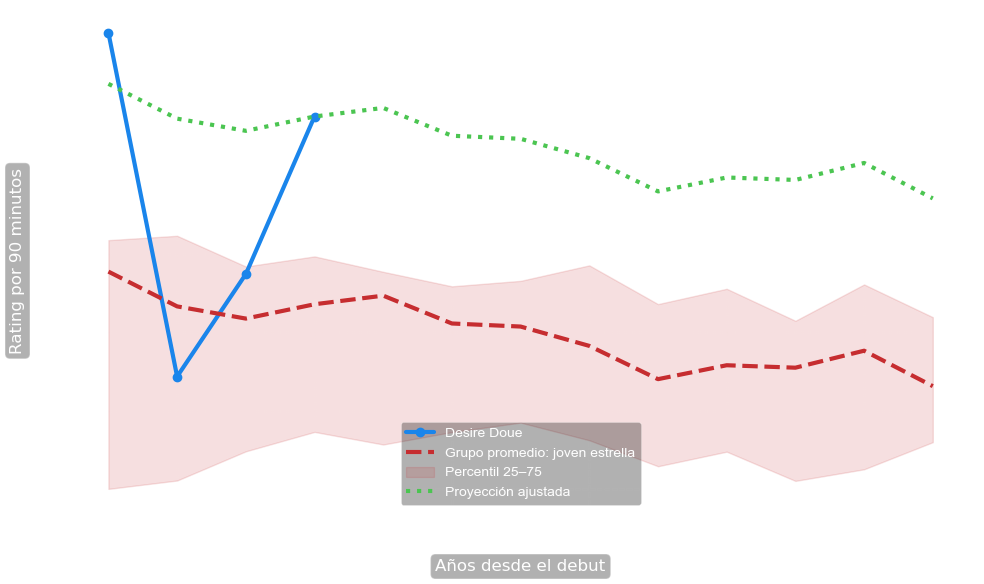

In [15]:
import sys
from pathlib import Path

# Añade la carpeta 'src' al sys.path
src_path = Path().resolve() / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from model_utils import load_model_assets
from model_runner import prepare_features, get_curve_by_group, adjust_projection
from stats import plot_rating_projection
from data_loader import load_future_metadata

import matplotlib.pyplot as plt

# Cargar modelo y features
model, le, df_curves, model_features = load_model_assets()

# Preparar input
player_id = "9e7483ff"
metadata = load_future_metadata()
player_name = metadata.loc[metadata["Player_ID"] == player_id, "Player_name"].values[0]
X_input, seasonal_df = prepare_features(player_id)
X_input = X_input.reindex(columns=model_features, fill_value=0)

# Predecir grupo
pred_encoded = model.predict(X_input)[0]
pred_label = le.inverse_transform([pred_encoded])[0]
print(f"✅ Grupo predicho por el modelo: **{pred_label}**")

# Obtener curva del grupo y ajustar proyección
group_curve = get_curve_by_group(pred_label)
print(group_curve.columns)

group_curve = adjust_projection(group_curve, seasonal_df)

# 🔒 Limitar a 13 años desde el debut
seasonal_df = seasonal_df[seasonal_df['year_since_debut'] <= 13]
group_curve = group_curve[group_curve['year_since_debut'] <= 13]

# Graficar
fig = plot_rating_projection(player_name, seasonal_df, group_curve, pred_label)
plt.show()

In [16]:
import os
from dotenv import load_dotenv
from pathlib import Path

# ✅ Carga explícita del .env desde el notebook (una vez por sesión)
dotenv_path = Path("../.env").resolve()
load_dotenv(dotenv_path)

# ✅ Verificación
print("🔑 Clave cargada:", os.getenv("GOOGLE_API_KEY")[:8])  # debería mostrar parte de la clave


🔑 Clave cargada: AIzaSyA7


In [17]:
import google.generativeai as genai

from dotenv import load_dotenv
import os
from pathlib import Path

load_dotenv(Path("../.env").resolve())
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# Lista los modelos accesibles
for model in genai.list_models():
    print(model.name, "→", model.supported_generation_methods)


models/embedding-gecko-001 → ['embedText', 'countTextTokens']
models/gemini-1.0-pro-vision-latest → ['generateContent', 'countTokens']
models/gemini-pro-vision → ['generateContent', 'countTokens']
models/gemini-1.5-pro-latest → ['generateContent', 'countTokens']
models/gemini-1.5-pro-001 → ['generateContent', 'countTokens', 'createCachedContent']
models/gemini-1.5-pro-002 → ['generateContent', 'countTokens', 'createCachedContent']
models/gemini-1.5-pro → ['generateContent', 'countTokens']
models/gemini-1.5-flash-latest → ['generateContent', 'countTokens']
models/gemini-1.5-flash-001 → ['generateContent', 'countTokens', 'createCachedContent']
models/gemini-1.5-flash-001-tuning → ['generateContent', 'countTokens', 'createTunedModel']
models/gemini-1.5-flash → ['generateContent', 'countTokens']
models/gemini-1.5-flash-002 → ['generateContent', 'countTokens', 'createCachedContent']
models/gemini-1.5-flash-8b → ['createCachedContent', 'generateContent', 'countTokens']
models/gemini-1.5-flas

In [18]:
from src.gemini_utils import generar_conclusion_gemini

prompt = "Resume el rendimiento de un jugador joven que aumenta sus minutos y rendimiento ofensivo durante dos años consecutivos."
respuesta = generar_conclusion_gemini(prompt, temperature=0.25)

print("🧠 Respuesta IA:", respuesta)

🧠 Respuesta IA: El joven jugador ha demostrado un notable progreso en los últimos dos años, mostrando un aumento constante en sus minutos de juego y su producción ofensiva.  Su curva de aprendizaje ha sido ascendente, reflejando una mejora significativa en su eficiencia y contribución al equipo.


In [19]:
print("📄 Columnas disponibles en logs:", group_curve.columns.tolist())


📄 Columnas disponibles en logs: ['peak_group', 'year_since_debut', 'rating_avg', 'rating_p25', 'rating_p75', 'projection']


In [20]:
from src.gemini_utils import generar_conclusion_gemini
from model_runner import predict_and_project_player
from data_loader import load_future_metadata
from player_processing import build_player_df
from datetime import datetime
import pandas as pd

def generar_conclusion_completa(player_id: str) -> str:
    fecha_actual = datetime(2025, 5, 23)
    fecha_str = fecha_actual.strftime("%d de %B de %Y").lstrip("0").capitalize()

    # Modelo y metadatos
    group_label, seasonal_df, group_curve = predict_and_project_player(player_id)
    metadata = load_future_metadata()
    player_name = metadata[metadata["Player_ID"] == player_id]["Player_name"].values[0]

    # Matchlogs
    matchlogs = build_player_df(player_id)
    matchlogs = matchlogs[matchlogs["Minutes"] > 0].sort_values("Date")
    debut_year = pd.to_datetime(matchlogs.iloc[0]["Date"]).year

    # Datos por temporada
    seasonal_df = seasonal_df.sort_values("year_since_debut")
    seasonal_df["Minutes"] = pd.to_numeric(seasonal_df["Minutes"], errors="coerce")
    seasonal_df["Goals"] = pd.to_numeric(seasonal_df.get("Goals", 0), errors="coerce")
    seasonal_df["Assists"] = pd.to_numeric(seasonal_df.get("Assists", 0), errors="coerce")
    seasonal_df["G+A"] = seasonal_df["Goals"] + seasonal_df["Assists"]
    seasonal_df["rating_per_90"] = pd.to_numeric(seasonal_df["rating_per_90"], errors="coerce")

    # Año debut
    debut_row = seasonal_df[seasonal_df["year_since_debut"] == 1].iloc[0]
    debut_minutes = int(debut_row["Minutes"])
    debut_ga = int(debut_row["G+A"])
    debut_rating = debut_row["rating_per_90"]

    # Año más productivo
    peak_prod_row = seasonal_df.loc[seasonal_df["G+A"].idxmax()]
    peak_year = debut_year + int(peak_prod_row["year_since_debut"]) - 1
    peak_ga = int(peak_prod_row["G+A"])
    peak_minutes = int(peak_prod_row["Minutes"])
    peak_rating = peak_prod_row["rating_per_90"]

    # Año actual
    current_row = seasonal_df[seasonal_df["year_since_debut"] == seasonal_df["year_since_debut"].max()].iloc[0]
    current_year = debut_year + int(current_row["year_since_debut"]) - 1
    current_ga = int(current_row["G+A"])
    current_minutes = int(current_row["Minutes"])
    current_rating = current_row["rating_per_90"]

    # Curva comparativa
    curva_jugador = seasonal_df.set_index("year_since_debut")["rating_per_90"]
    curva_grupo = group_curve.set_index("year_since_debut")["rating_avg"]
    comparativa = "por encima" if (curva_jugador - curva_grupo).mean() > 0.15 else "en línea con"

    # Prompt final
    prompt = f"""
📝 Informe de Scouting: {player_name} – {fecha_str}

Jugador: {player_name}  
Clasificación del modelo: {group_label}

El jugador debutó en {debut_year} con {debut_minutes} minutos y {debut_ga} goles + asistencias.  
Ese primer año, a pesar de la baja participación, mostró eficacia: aportó en pocos minutos, reflejando un buen nivel de adaptación.

Desde entonces, su progresión ha sido constante.  
En {peak_year}, alcanzó su año más productivo con {peak_ga} goles + asistencias en {peak_minutes} minutos.  
Actualmente ({current_year}), está sumando {current_minutes} minutos y {current_ga} G+A, lo que indica que **está cuajando una temporada sólida y de impacto ofensivo**.

Su curva de evolución, especialmente en producción ofensiva y carga de minutos, refleja un perfil **en crecimiento**.  
En términos de rendimiento global, su desarrollo comparado con el grupo proyectado es **{comparativa} la media**, lo que sugiere que puede consolidarse como un jugador diferencial si mantiene esta línea.

El rating a lo largo de los años ha mostrado subidas y bajadas, pero no debe interpretarse de forma aislada:  
- En su debut, el alto rating respondió a una **gran eficacia con pocos minutos**.  
- En temporadas de mayor carga, el impacto ofensivo ha crecido, aunque el rating puede haberse estabilizado por el rol más exigente o nuevas responsabilidades.

🎯 En resumen, es un perfil que combina crecimiento, adaptación progresiva y eficacia ofensiva.  
Para confirmar su proyección, será clave evaluar su evolución en consistencia y aportar con regularidad.  
Se recomienda un seguimiento continuo y análisis tácticos detallados para confirmar su tendencia positiva a largo plazo.
"""

    return generar_conclusion_gemini(prompt, temperature=0.25)


In [21]:
conclusion = generar_conclusion_completa("a2728fbf")  # Endrick
print(conclusion)


🧪 HEAD desde Streamlit para a2728fbf:
        Date  Minutes  Goals  Assists        Age
0 2023-04-15     60.0      1        0  16.733744
1 2023-04-20     36.0      0        0  16.747433
2 2023-04-23     22.0      0        0  16.755647
3 2023-05-07     26.0      1        0  16.793977
4 2023-05-10     14.0      0        0  16.802190
✅ Filas finales en player_model_df: 1
🧠 Vector model input para a2728fbf (Streamlit):
                            0
year_since_debut             
rating_year_1        5.882970
rating_year_2        4.711564
rating_year_3        6.236888
rating_year_4        2.502703
age_year_1          16.267136
age_year_2          17.087699
age_year_3          18.016612
age_year_4          18.632817
minutes_year_1     307.000000
minutes_year_2    1734.000000
minutes_year_3    1237.000000
minutes_year_4     681.000000
growth_2_1          -1.171406
growth_3_2           1.525324
rating_trend         0.353918
minutes_trend      930.000000
avg_rating           4.833531
sum_minutes

In [26]:
import requests

response = requests.post(
    "https://JuanmaCM7-gemini-endpoint.hf.space/generate",
    json={"prompt": "Resume el rendimiento de Desire Doue"}
)

print(response.json())

{'error': '400 API key not valid. Please pass a valid API key. [reason: "API_KEY_INVALID"\ndomain: "googleapis.com"\nmetadata {\n  key: "service"\n  value: "generativelanguage.googleapis.com"\n}\n, locale: "en-US"\nmessage: "API key not valid. Please pass a valid API key."\n]'}
